In [1]:
import torch
import torchvision
from torchinfo import summary
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys, os
import numpy as np
sys.path.insert(0, '../scripts') # add 'scrips' subfolder to sys path for easier import 
from Dataset import get_cifar10, get_cifar100, CIFAR100_Fine_labels, CIFAR10_labels
from Dataset import ImageNetDataset, ConvertToPlotableImage
from Models import get_Model
from Utils import evaluate

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# classify a cifar-10 test image using a pre-trained resnet8. Examine the soft information in it's output.

## load cifar10 pre-trained resnet-8 model 

In [2]:
model = get_Model('ResNet-8', NUM_CLASS = 10)
weight_file = 'ResNet-8_from-scratch_CIFAR-10_pretrains_350epochs_ValAcc:88.74_2023-08-01.pth' 
model.load_state_dict(torch.load(os.path.join('/home/chitraz/Documents/UoS_MSc/EEEM056_Project/Experiments/saves',weight_file)))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1

## get a sample from cifar10 test  

Image Index: 420, GT: tensor([4]) = deer


Text(0.5, 1.0, '(a) Deer image drawn from CIFAR-10 test set')

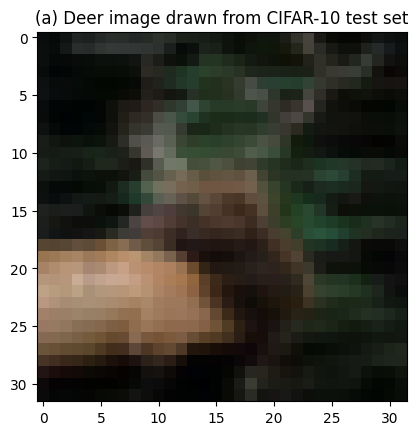

In [3]:
dataset_test = get_cifar10('test', Dataset_dir = '/home/chitraz/Documents/UoS_MSc/EEEM056_Project/Experiments/dataset')
dataloader_test  = torch.utils.data.DataLoader(dataset_test, batch_size = 128, shuffle = False, num_workers = 16)

test_img, gt, idx = dataset_test[420]

test_img_plot = ConvertToPlotableImage(test_img,MEAN_PIX=[0.4914, 0.4822, 0.4465],STD_PIX=[0.2023, 0.1994, 0.2010])
plt.imshow(test_img_plot)
print('Image Index: {}, GT: {} = {}'.format(idx, gt, CIFAR10_labels[gt]))
test_img1 = test_img.unsqueeze(0).to(device)
plt.title('(a) Deer image drawn from CIFAR-10 test set')

## Evalute loaded model's accuracy on Cifar10 test set

In [4]:
# create datalader for cifar10 test set
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = 512, num_workers = 16)

#evaluate pre-trained model on cifar-10 test set 
testAcc = evaluate(model, device, test_loader)
print('Test Acc@1: {}%'.format(testAcc))

100%|██████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.55it/s]

Test Acc@1: 88.73%


## Feedforward test image into model and get output logits

In [5]:
# get logits for example image
with torch.no_grad():
    logits = model(test_img1)

## plot logits class scores 

Text(0.5, 1.0, 'Logits')

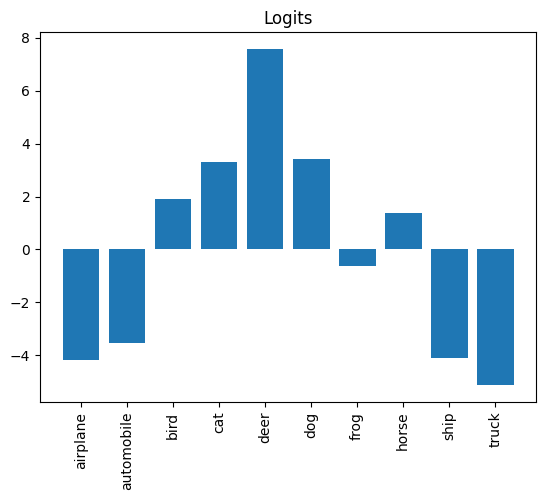

In [6]:
classes = [CIFAR10_labels[i] for i in range(10)]
plt.bar(classes, logits.cpu().detach().numpy().tolist()[0])
plt.xticks(rotation=90)
plt.title('Logits')

## plot class probabilty distrubution

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'airplane'),
  Text(1, 0, 'automobile'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')])

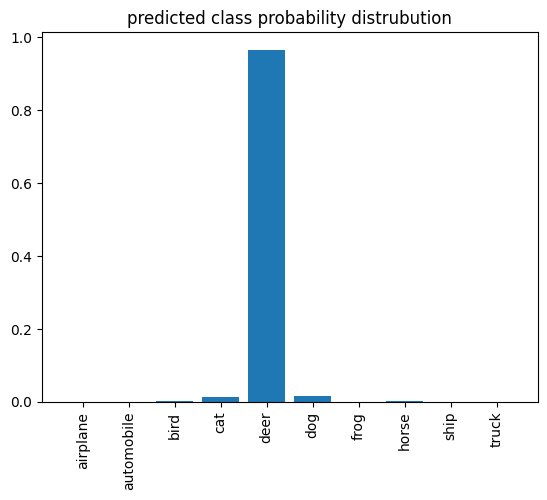

In [7]:
# compute class probabilty distrubution using standard softmax function
class_prob = torch.nn.functional.softmax(logits, dim=1)
plt.bar(classes, class_prob.cpu().detach().numpy().tolist()[0])
plt.title('predicted class probability distrubution')
plt.xticks(rotation=90)


## plot soften class probabilty distrubutions

Text(0.5, 1.0, 'soften class probability distrubution using temperture')

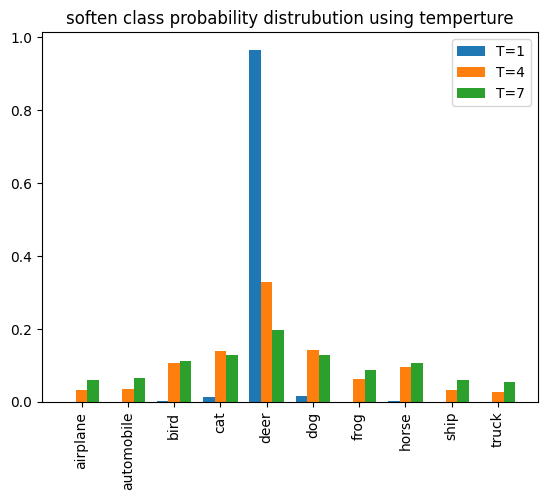

In [10]:
# get predicted class probabilty distrubutions at T = 1, 4, 7
class_prob_1 = torch.nn.functional.softmax(logits/1, dim=1)
class_prob_4 = torch.nn.functional.softmax(logits/5, dim=1)
class_prob_7 = torch.nn.functional.softmax(logits/10, dim=1)

x = np.arange(len(classes))
width = 0.25
bars1 = plt.bar(x - width, class_prob_1.cpu().detach().numpy().tolist()[0], width=width)
bars4 = plt.bar(x , class_prob_4.cpu().detach().numpy().tolist()[0], width=width)#, hatch='///')
bars7 = plt.bar(x + width, class_prob_7.cpu().detach().numpy().tolist()[0], width=width)#, hatch='ooo')


plt.xticks(x, classes)
plt.xticks(rotation=90)
plt.legend(('T=1', 'T=4', 'T=7'))
plt.title('soften class probability distrubution using temperture')

## Plot everything together

Text(0.5, 1.0, 'd) Soften Class Probabilities')

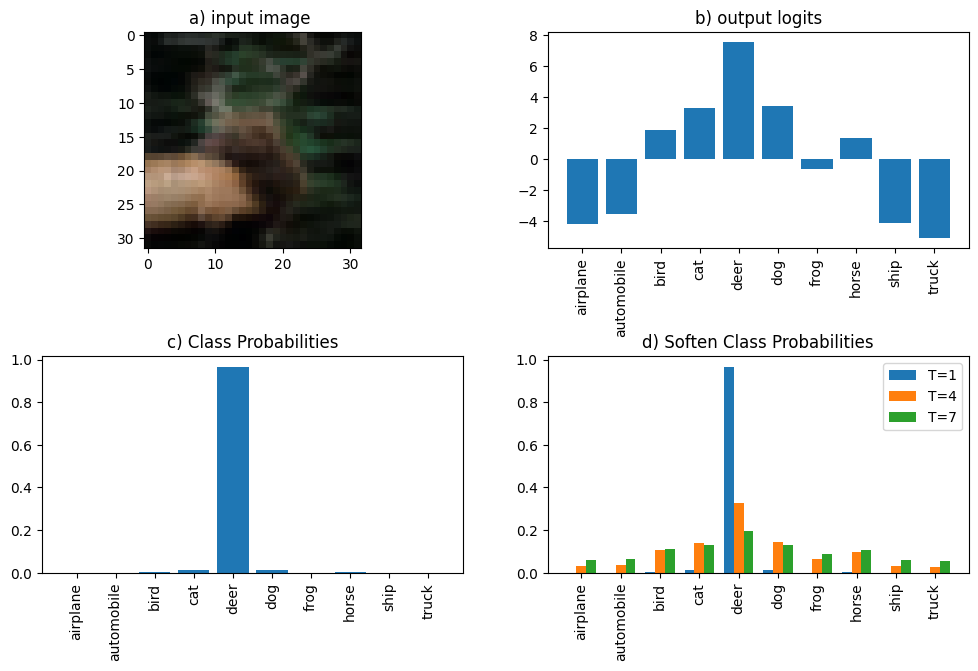

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10,6))
fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.5)

# input image
axs[0,0].imshow(test_img_plot)
axs[0,0].set_title('a) input image ')

# logits: class scores
axs[0,1].bar(classes, logits.cpu().detach().numpy().tolist()[0])
axs[0,1].tick_params(axis='x', rotation=90)
axs[0,1].set_title('b) output logits')

# class prob
axs[1,0].bar(classes, class_prob.cpu().detach().numpy().tolist()[0])
axs[1,0].tick_params(axis='x', rotation=90)
axs[1,0].set_title('c) Class Probabilities')

# soften class prob
axs[1,1].bar(x - width, class_prob_1.cpu().detach().numpy().tolist()[0], width=width)
axs[1,1].bar(x , class_prob_4.cpu().detach().numpy().tolist()[0], width=width)
axs[1,1].bar(x + width, class_prob_7.cpu().detach().numpy().tolist()[0], width=width)
axs[1,1].set_xticks(x, classes)
axs[1,1].legend(('T=1', 'T=4', 'T=7'))
axs[1,1].tick_params(axis='x', rotation=90)
axs[1,1].set_title('d) Soften Class Probabilities')

